In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
import matplotlib.pyplot as plt

In [4]:
import sys 
import pickle

In [5]:
sys.path.append('../../')

In [6]:
from omd2l.data.StocksData import StocksData

In [7]:
with open("./feat_alpha_df.pickle", "rb") as handle:
    data = pickle.load(handle)

In [8]:
data['ff_alpha_direction'] = 1.0*(data['ff_alpha']>0)

In [9]:
FEATURES = [ 
 'px_rank',
 'range',
 'prior_ret',
 'DollarVolume',
 'Beta',
 'SecBeta',
 'market_relative_prior_ret',
 'sector_relative_prior_ret' ]
RESPONSE = ['ff_alpha_direction']

In [10]:
data['tradeDate'] = pd.to_datetime(data['date']).dt.date

In [11]:
data[FEATURES] = data.groupby('tradeDate')[FEATURES].apply(
    lambda x: (x - x.mean()) / (x.std())).copy()

<AxesSubplot:>

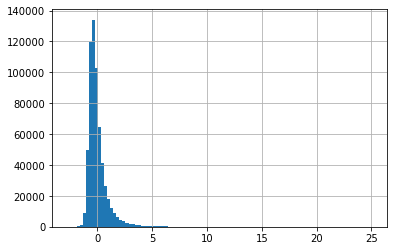

In [12]:
data['range'].hist(bins=100)

In [13]:
data = StocksData(batch_size=1000,features=FEATURES, response=RESPONSE)

In [14]:
data.preprocess()

In [15]:
from sklearn.model_selection import KFold

In [16]:
with open("./feat_alpha_df.pickle", "rb") as handle:
    dataset = pickle.load(handle)
dataset['ff_alpha_direction'] = 1.0*(dataset['ff_alpha']>0)
dataset['tradeDate'] = pd.to_datetime(dataset['date']).dt.date
dataset.sort_values(by = 'tradeDate',ascending=True, inplace = True)
dataset.reset_index(drop = True, inplace = True)

In [17]:
from torch import nn

In [18]:
class SoftmaxRegressionTabular(nn.Module):
    def __init__(self, number_classes=2):
        super().__init__()
        self.net =  nn.LazyLinear(number_classes)

    def forward(self, X):
        y_pred = torch.sigmoid(self.net(X))
        return y_pred



In [19]:
device = "cpu" # torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

In [20]:
num_epochs=10
batch_size=128
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)

In [21]:
from torch.nn import functional as F
def loss_fn(Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')

In [22]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for train_data, train_labels in dataloader:

        train_data, train_labels = train_data.to(device),train_labels.to(device)
        optimizer.zero_grad()
        output = model(train_data)
        print(output)
        loss = loss_fn(output,train_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * train_data.size(0)
        scores, predictions = torch.max(output.data, 1)
#         train_correct += (predictions == train_labels).sum().item()
        train_correct += np.diag(confusion_matrix(y_pred=predictions  , y_true =  train_labels ) ).sum()

    return train_loss,train_correct

In [23]:
 def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
        for validation_data, validation_labels in dataloader:
            validation_data, validation_labels = validation_data.to(device),validation_labels.to(device)
            output = model(validation_data)
            loss=loss_fn(output,validation_labels)
            valid_loss+=loss.item()*validation_data.size(0)
            scores, predictions = torch.max(output.data,1)
#             val_correct+=(predictions == validation_labels).sum().item()
            val_correct+=np.diag(confusion_matrix(y_pred=predictions  , y_true =  validation_labels ) ).sum()

    return valid_loss,val_correct

In [24]:
dataset.tail()

,ticker,date,open,high,low,close,volume,dividends,closeunadj,lastupdated,...,sector_relative_prior_ret_250,Mkt-RF,SMB-RF,HML-RF,RMW-RF,CMA-RF,RF,ff_alpha,ff_alpha_direction,tradeDate
616915,PCH,2020-11-24,45.52,46.370,45.26,46.05,473587.0,0.0,46.05,2020-11-24,...,683.380856,1.56,0.48,2.76,0.53,0.54,0.0,-53.301433,0.0,2020-11-24
616916,MCD,2020-11-24,219.01,221.250,218.25,219.71,3816710.0,0.0,219.71,2020-11-24,...,-1451.959187,1.56,0.48,2.76,0.53,0.54,0.0,20.766116,1.0,2020-11-24
616917,PPG,2020-11-24,146.40,148.090,145.89,147.93,1453805.0,0.0,147.93,2020-11-24,...,-609.687509,1.56,0.48,2.76,0.53,0.54,0.0,-19.162655,0.0,2020-11-24
616918,HFC,2020-11-24,25.28,26.385,24.71,25.80,2973595.0,0.0,25.80,2020-11-24,...,-4179.360632,1.56,0.48,2.76,0.53,0.54,0.0,34.359212,1.0,2020-11-24
616919,ZTS,2020-11-24,164.39,166.250,160.47,161.06,2249396.0,0.0,161.06,2020-11-24,...,1609.455428,1.56,0.48,2.76,0.53,0.54,0.0,45.145271,1.0,2020-11-24


In [25]:
kfold = KFold(n_splits=5, shuffle=True)
# # K-fold Cross Validation model evaluation
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_data = dataset.iloc[train_ids,:]
    test_data = dataset.iloc[test_ids,:]
    
#     data.x = data.x.to(torch.float)


    
    train_tensors = TensorDataset(torch.from_numpy(train_data[FEATURES].values).to(torch.float) ,  # X
                                torch.from_numpy(train_data[RESPONSE].values).to(torch.float) )   # Y

    train_loader = torch.utils.data.DataLoader( train_tensors,
                                           batch_size=1000,
                                           shuffle=True )
    
    test_tensors = TensorDataset(torch.from_numpy(test_data[FEATURES].values).to(torch.float) ,  # X
                                torch.from_numpy(test_data[RESPONSE].values).to(torch.float) )   # Y

    test_loader = torch.utils.data.DataLoader( test_tensors,
                                           batch_size=1000,
                                           shuffle=True )    

    
    model = SoftmaxRegressionTabular()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    for epoch in range(num_epochs):
        
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_ids)
        train_acc = train_correct / len(train_ids) * 100
        test_loss = test_loss / len(test_ids)
        test_acc = test_correct / len(test_ids) * 100

        print(f"Epoch:{epoch + 1}/{num_epochs} AVG Training Loss:{train_loss} AVG Test Loss:{test_loss} AVG Training Acc {train_acc}   AVG Test Acc {test_acc}" )
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)   
    

FOLD 0
--------------------------------


/Users/oualid/opt/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]], grad_fn=<SigmoidBackward0>)


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
asa

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
# # K-fold Cross Validation model evaluation
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_data = dataset.iloc[train_ids,:]
    test_data = dataset.iloc[test_ids,:]
    
#     data.x = data.x.to(torch.float)


    
    train_tensors = TensorDataset(torch.from_numpy(train_data[FEATURES].values).to(torch.float) ,  # X
                                torch.from_numpy(train_data[RESPONSE].values).to(torch.long) )   # Y

    train_loader = torch.utils.data.DataLoader( train_tensors,
                                           batch_size=1000,
                                           shuffle=True )
    
    test_tensors = TensorDataset(torch.from_numpy(test_data[FEATURES].values).to(torch.float) ,  # X
                                torch.from_numpy(test_data[RESPONSE].values).to(torch.long) )   # Y

    test_loader = torch.utils.data.DataLoader( test_tensors,
                                           batch_size=1000,
                                           shuffle=True )    

    
    model = SoftmaxRegressionTabular()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    for epoch in range(num_epochs):
        
#         train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        train_loss, train_correct=0.0,0
        model.train()
        for train_data, train_labels in train_loader:

            train_data, train_labels = train_data.to(device),train_labels.to(device)
            optimizer.zero_grad()
            output = model(train_data)
            loss = loss_fn(output,train_labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * train_data.size(0)
            scores, predictions = torch.max(output.data, 1)
            train_correct += np.diag(confusion_matrix(y_pred=predictions  , y_true =  train_labels ) ).sum()
        
    

In [ ]:
loss.item() 

In [ ]:
train_data.size(0)

In [ ]:
train_correct/len(train_ids)

In [ ]:

train_loss, train_correct

In [ ]:
len(train_labels)

In [ ]:
(predictions == train_labels).sum()

In [ ]:
train_labels.detach().cpu().numpy()

In [ ]:
(predictions == np.array([ item[0] for item in train_labels.tolist()]) ).sum()

In [ ]:
(predictions == np.array([ item[0] for item in train_labels.tolist()]) )

In [ ]:
predictions.tolist()

In [ ]:
accuracy_score(y_pred=predictions.tolist() , y_true =[ item[0] for item in train_labels.tolist()])